# Validate the 3D cyl mesh on a DC Vertical electric dipole

- use a simple mesh and compare the DC solution on the cyl symetric and 3D cyl meshes to the analytic for an electric dipole at zero frequency

In [1]:
# core python
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
from scipy.constants import mu_0, inch, foot

# SimPEG
import discretize
from discretize import utils
from SimPEG.EM.Static import DC
from SimPEG import Utils, Maps
import geoana
from pymatsolver import Pardiso

# casing utils
import casingSimulations

%matplotlib inline

In [2]:
sigma_back = 1e-1

In [3]:
csx, ncx, npadx = 1, 50, 30
ncy = 10
csz, ncz, npadz = 1, 50, 30

hx = Utils.meshTensor([(csx, ncx), (csx, npadx, 1.3)])
hy = 2*np.pi / ncy * np.ones(ncy)
hz = Utils.meshTensor([(csz, npadz, -1.3), (csz, ncz), (csz, npadz, 1.3)])

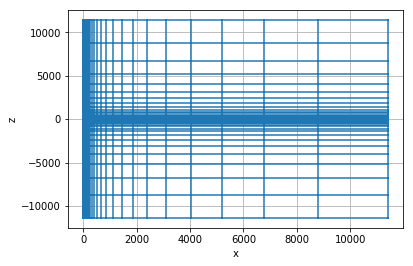

In [4]:
mesh2D = discretize.CylMesh([hx, 1., hz], x0='00C')
mesh2D.plotGrid()

In [5]:
mesh3D = discretize.CylMesh([hx, hy, hz], x0='00C')

/anaconda/lib/python2.7/site-packages/matplotlib/projections/polar.py:58: RuntimeWarning: invalid value encountered in less
  mask = r < 0


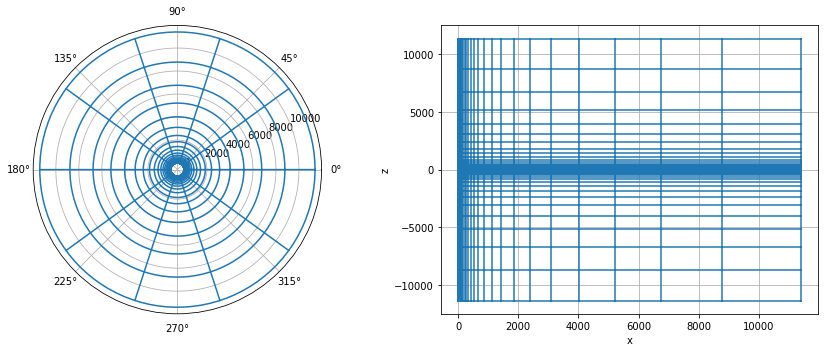

In [6]:
mesh3D.plotGrid()

In [7]:
src_a = np.r_[csx/2., 0., csz*7/2.]
src_b = np.r_[csx/2., 0., -csz*7/2.]

(-10.0, 10.0)

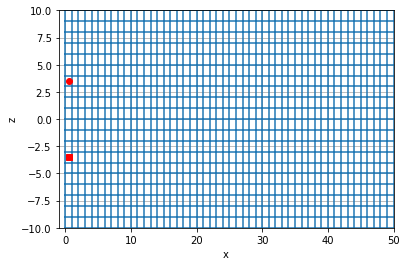

In [8]:
fig, ax = plt.subplots(1, 1)
mesh3D.plotGrid(ax=ax, slice='theta')

ax.plot(src_a[0], src_a[2], 'ro')
ax.plot(src_b[0], src_b[2], 'rs')

ax.set_xlim([-1., 50.])
ax.set_ylim([-10., 10.])

In [9]:
prob2D = DC.Problem3D_CC(mesh2D, sigmaMap=Maps.SurjectFull(mesh2D), bc_type='Dirichlet', Solver=Pardiso)
prob3D = DC.Problem3D_CC(mesh3D, sigmaMap=Maps.SurjectFull(mesh3D), bc_type='Dirichlet', Solver=Pardiso)

Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.


In [10]:
survey2D = DC.Survey([DC.Src.Dipole([], src_a, src_b)])
survey3D = DC.Survey([DC.Src.Dipole([], src_a, src_b)])

In [11]:
prob2D.pair(survey2D)
prob3D.pair(survey3D)

In [12]:
%time
fields2D = prob2D.fields(np.r_[sigma_back])

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 11.2 µs


In [13]:
%time
fields3D = prob3D.fields(np.r_[sigma_back])

CPU times: user 9 µs, sys: 1 µs, total: 10 µs
Wall time: 10 µs


In [14]:
src2D = survey2D.srcList[0]
src3D = survey3D.srcList[0]

j = fields2D[src2D, 'j']
j3D = fields3D[src3D, 'j']

e = fields2D[src2D, 'e']
e3D = fields3D[src3D, 'e']

jplt = casingSimulations.face3DthetaSlice(mesh3D, j3D)
eplt = casingSimulations.face3DthetaSlice(mesh3D, e3D)

phiplt = utils.mkvc(fields3D[src3D, 'phi'].reshape(mesh3D.vnC, order='F')[:,0,:])

[(-50.0, 50), (-50.0, 50)]

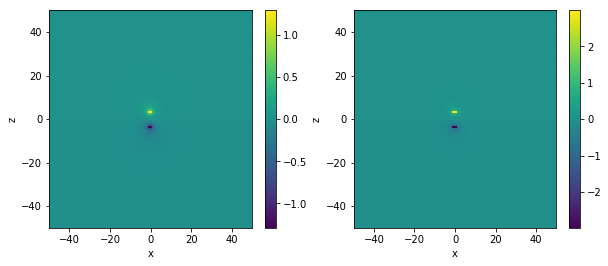

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4))

plt.colorbar(mesh2D.plotImage(fields2D[src2D, 'phi'], mirror=True, ax=ax[0])[0], ax=ax[0])
plt.colorbar(mesh2D.plotImage(phiplt, mirror=True, ax=ax[1])[0], ax=ax[1])

[a.set_xlim([-50., 50]) for a in ax]
[a.set_ylim([-50., 50]) for a in ax]

In [16]:
length = src_a[2] - src_b[2]

edipole = geoana.em.fdem.ElectricDipoleWholeSpace(
    location=np.r_[0., 0., 0.], frequency=0., sigma=sigma_back, 
    current=1., length=length, orientation='z'
)

eana_x = edipole.electric_field(mesh2D.gridFx)[:, 0]
eana_z = edipole.electric_field(mesh2D.gridFz)[:, 2]

eana = np.hstack([eana_x, eana_z])
jana = sigma_back * eana

ecc_ana = edipole.electric_field(mesh2D.gridCC)
eccx = ecc_ana[:,0]
eccz = ecc_ana[:,2]

ecc_ana = utils.mkvc(np.hstack([eccx, eccz]),2)

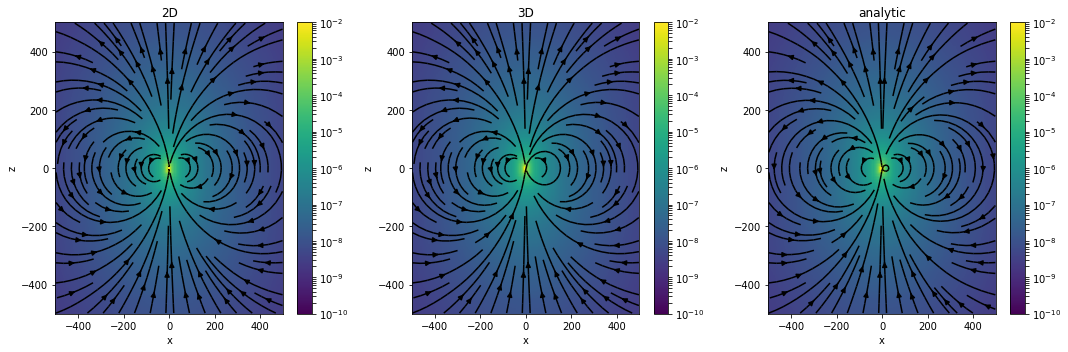

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

pltargs = {
    'mirror':True,
    'range_x':np.r_[-500., 500.],
    'range_y':np.r_[-500., 500.],
    'sample_grid':np.r_[5.,5.],
    'clim':np.r_[1e-10, 1e-2]
}

casingSimulations.plotFace2D(mesh2D, j, ax=ax[0], **pltargs)
casingSimulations.plotFace2D(mesh2D, jplt, ax=ax[1], **pltargs)
casingSimulations.plotFace2D(mesh2D, jana, ax=ax[2], **pltargs)
[a.set_title(t) for a, t in zip(ax, ["2D", "3D", "analytic"])]
plt.tight_layout()

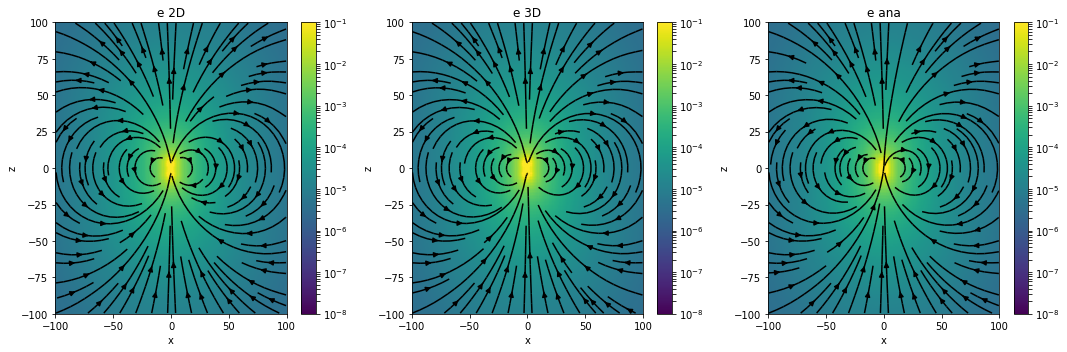

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

pltargs = {
    'mirror':True,
    'range_x':np.r_[-100., 100.],
    'range_y':np.r_[-100., 100.],
    'sample_grid':np.r_[1.,1.],
    'clim':np.r_[1e-8, 1e-1]
}

casingSimulations.plotFace2D(
    mesh2D, e, ax=ax[0], **pltargs
)
casingSimulations.plotFace2D(
    mesh2D, eplt, ax=ax[1], **pltargs
)
casingSimulations.plotFace2D(
    mesh2D, eana, ax=ax[2], **pltargs
)

ax[0].set_title('e 2D')
ax[1].set_title('e 3D')
ax[2].set_title('e ana')

plt.tight_layout()

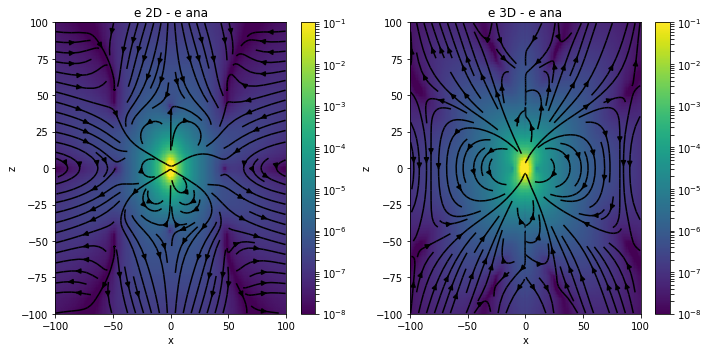

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

pltargs = {
    'mirror':True,
    'range_x':np.r_[-100., 100.],
    'range_y':np.r_[-100., 100.],
    'sample_grid':np.r_[1.,1.],
    'clim':np.r_[1e-8, 1e-1]
}

casingSimulations.plotFace2D(
    mesh2D, discretize.utils.mkvc(e)-eana, ax=ax[0], **pltargs
)
casingSimulations.plotFace2D(
    mesh2D, discretize.utils.mkvc(eplt)-eana, ax=ax[1], **pltargs
)

ax[0].set_title('e 2D - e ana')
ax[1].set_title('e 3D - e ana')


plt.tight_layout()

## Ensure agreement away from source

In [20]:
# line plots
e3D_x = eplt[:mesh2D.vnF[0]].reshape([mesh2D.vnFx[0], mesh2D.vnFx[2]], order='F')
e3D_z = eplt[-mesh2D.vnF[2]:].reshape([mesh2D.vnFz[0], mesh2D.vnFz[2]], order='F')

e2D_x = e[:mesh2D.vnF[0]].reshape([mesh2D.vnFx[0], mesh2D.vnFx[2]], order='F')
e2D_z = e[-mesh2D.vnF[2]:].reshape([mesh2D.vnFz[0], mesh2D.vnFz[2]], order='F')

eana_x = eana_x.reshape([mesh2D.vnFx[0], mesh2D.vnFx[2]], order='F')
eana_z = eana_z.reshape([mesh2D.vnFz[0], mesh2D.vnFz[2]], order='F')

In [21]:
def plot_lines(x, e2D=None, e3D=None, eana=None, xlim=[0., 100.], name=None, xlabel=None):
    fig, ax = plt.subplots(3, 1, figsize=(10,10))
    ax = utils.mkvc(ax)
    
    plt_ind = (x > xlim[0]) & (x < xlim[1])
    
    x = x[plt_ind]
    if e2D is not None: e2D = e2D[plt_ind]
    if e3D is not None: e3D = e3D[plt_ind]
    if eana is not None: eana = eana[plt_ind]
    
    # Plot real
    if any(eana.real > 0): 
        if e2D is not None: ax[0].semilogy(x, e2D.real, '-b', label='2D')
        if e3D is not None: ax[0].semilogy(x, e3D.real, '-g', label='3D')
        if eana is not None: ax[0].semilogy(x, eana.real, '-r', label='ana')
    if any(eana.real < 0): 
        if e2D is not None: ax[0].semilogy(x, -e2D.real, '--b', label='2D')
        if e3D is not None: ax[0].semilogy(x, -e3D.real, '--g', label='3D')
        if eana is not None: ax[0].semilogy(x, -eana.real, '--r', label='ana')
        
    ax[0].set_xlim(xlim)
    ax[0].set_title('{}'.format(name))
    ax[0].legend()


    if e2D is not None: ax[1].semilogy(x, np.absolute(e2D.real - eana.real), '-b', label='2D')
    if e3D is not None: ax[1].semilogy(x, np.absolute(e3D.real - eana.real), '-g', label='3D')

    ax[1].set_xlim(xlim)
    ax[1].set_title('{} error'.format(name))
    ax[1].legend()

    if e2D is not None: ax[2].plot(
        x, (e2D.real - eana.real)/(eana.real), '-b', label='2D'
    )
    if e3D is not None: ax[2].plot(
        x, (e3D.real - eana.real)/(eana.real), '-g', label='3D'
    )

    ax[2].set_xlim(xlim)
    ax[2].set_ylim(0.1*np.r_[-1, 1])
    ax[2].set_title('{} error ratio'.format(name))
    ax[2].legend()
        
    [a.set_ylim([np.absolute(eana).min()*0.05, np.absolute(eana).max()*2]) for a in ax[:2]]
    [a.grid(which='both', linestyle='-', color=[0.8, 0.8, 0.8, 0.5], linewidth=0.5) for a in ax]
    
    if xlabel is not None:
        [a.set_xlabel(xlabel) for a in ax]
    plt.tight_layout()
    
    return fig, ax

    

looking at z=20.5


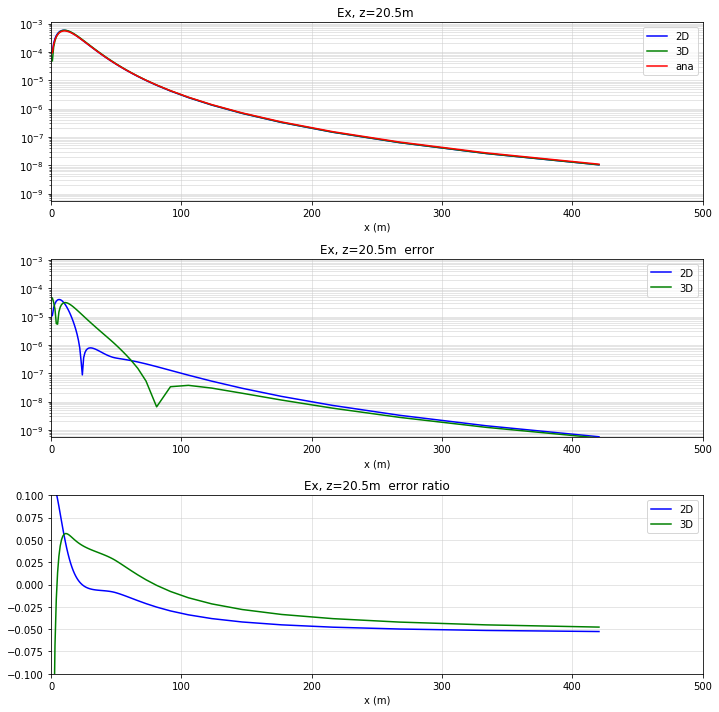

In [22]:
z_ind = mesh2D.vnC[2]/2 + 20
print('looking at z={}'.format(mesh2D.vectorCCz[z_ind]))

fig, ax = plot_lines(
    mesh2D.vectorNx, e2D_x[:, z_ind], e3D_x[:, z_ind], eana_x[:, z_ind], xlim=[0., 500.], 
    name='Ex, z={}m '.format(mesh2D.vectorCCz[z_ind]), xlabel='x (m)'
)

looking at x=15.5


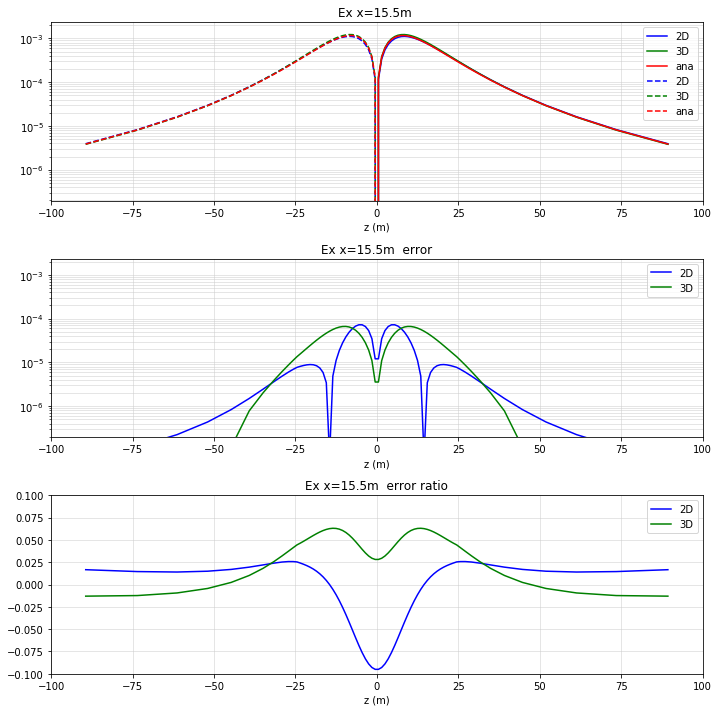

In [23]:
x_ind =  15
print('looking at x={}'.format(mesh2D.vectorCCx[x_ind]))

fig, ax = plot_lines(
    mesh2D.vectorCCz, e2D_x[x_ind, :], e3D_x[x_ind, :], eana_x[x_ind, :], xlim=[-100., 100.], 
    name='Ex x={}m '.format(mesh2D.vectorCCx[x_ind]), xlabel = 'z (m)'
)

looking at z=20.5


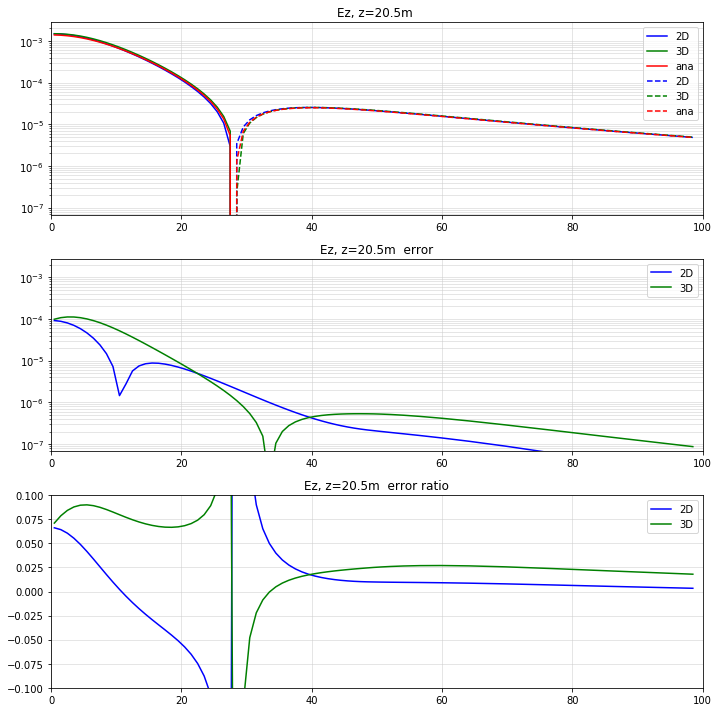

In [24]:
z_ind = mesh2D.vnC[2]/2 + 20
print('looking at z={}'.format(mesh2D.vectorCCz[z_ind]))

fig, ax = plot_lines(
    mesh2D.vectorCCx, e2D_z[:, z_ind], e3D_z[:, z_ind], eana_z[:, z_ind], xlim=[0., 100.], 
    name='Ez, z={}m '.format(mesh2D.vectorCCz[z_ind])
)

looking at x=15.5


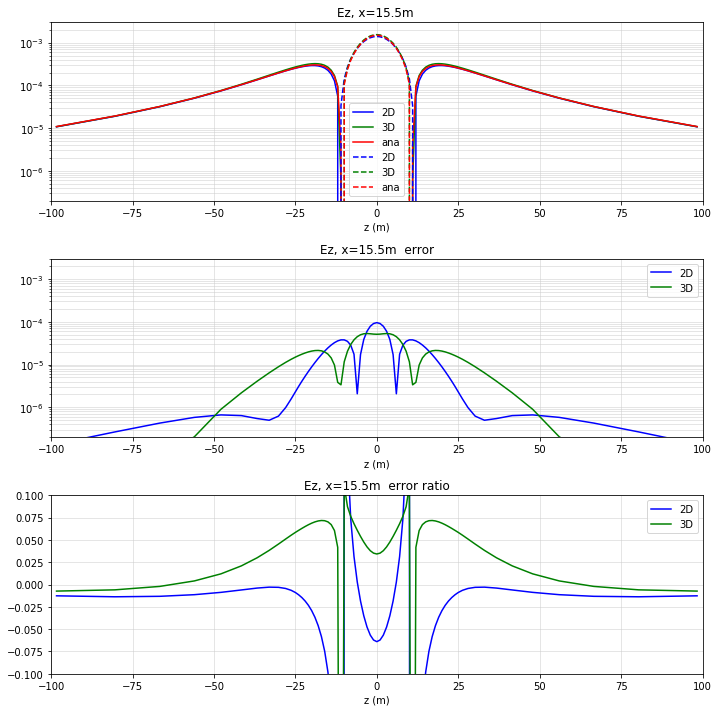

In [25]:
x_ind =  15
print('looking at x={}'.format(mesh2D.vectorCCx[x_ind]))

fig, ax = plot_lines(
    mesh2D.vectorNz, e2D_z[x_ind, :], e3D_z[x_ind, :], eana_z[x_ind, :], xlim=[-100., 100.], 
    name='Ez, x={}m '.format(mesh2D.vectorCCx[x_ind]), xlabel='z (m)'
)

In [26]:
def normalized_error(val1, val2):
    return np.linalg.norm(val1 - val2) / np.linalg.norm(0.5*(val1+val2))

In [27]:
tol = 0.08

In [28]:
assert normalized_error(e2D_x[:, z_ind], eana_x[:, z_ind]) < tol
assert normalized_error(e3D_x[:, z_ind], eana_x[:, z_ind]) < tol

In [29]:
assert normalized_error(e2D_x[x_ind, :], eana_x[x_ind, :]) < tol
assert normalized_error(e3D_x[x_ind,:], eana_x[x_ind, :]) < tol

In [30]:
assert normalized_error(e2D_z[:, z_ind], eana_z[:, z_ind]) < tol
assert normalized_error(e3D_z[:, z_ind], eana_z[:, z_ind]) < tol

In [31]:
assert normalized_error(e2D_z[x_ind, :], eana_z[x_ind, :]) < tol
assert normalized_error(e3D_z[x_ind,:], eana_z[x_ind, :]) < tol